In [1]:
%%capture
!pip install pyspark
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
sns.set_palette('rainbow')
sns.set_style('whitegrid')
import plotly.express as px
# these 2 lines fix a sporatic loading error in plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style('darkgrid')
# pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col


from sklearn.pipeline import Pipeline
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

CSV_FILE= '/content/sample_data/Final database.csv'


In [ ]:
# from pyspark.ml.regression import LinearRegression
# from pyspark.mllib.evaluation import RegressionMetrics

# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
# from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.evaluation import RegressionEvaluator

From SparkByExample:
> A spark session unifies all the different contexts, and you can access all the different contexts by invoking them on the spark session object. A Spark “driver” is an application that creates a SparkContext for executing one or more jobs in the Spark cluster. It allows your Spark/PySpark application to access Spark Cluster with the help of Resource Manager.
>
> When you create a SparkSession object, SparkContext is also created and can be retrieved using spark.sparkContext. SparkContext will be created only once for an application; even if you try to create another SparkContext, it still returns existing SparkContext.

In [2]:
spark = SparkSession.builder.master("local[2]").appName("Spotify-Huge-Dataset").getOrCreate() #.enableHiveSupport()
spark

In [3]:
# Old way depreciated in 3.0.0
sc = spark.sparkContext
sqlContext = SQLContext(sc)
# sqlContext = SQLContext(spark)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Note I'm fixing the numerical features after loading the df. This is much slower than defining the schema before loading into a spark dataframe. I'll come back and define the schema explicitely later when I have some free time.

In [4]:
df = spark.read.option("header", True).csv(CSV_FILE)
df = df.withColumn("Release_date", F.to_date("Release_date", "yyyy-MM-dd"))
numerical_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
                      'instrumentalness', 'tempo', 'duration_ms',
                      'time_signature', 'Days_since_release', 'n_words']

for c in numerical_features:
    df = df.withColumn(c, df[c].cast("float"))

cols_to_drop = ['syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing']
for c in cols_to_drop:
    df.drop(c).collect()

df.printSchema()
# df.show(n=1, truncate=False, vertical=True)

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: date (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acoustics: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveliness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nul

# EDA
Some good SQL queries, Plotly figures, and examples of using pyspark to filter results from a large dataset.

In [7]:
# how many unique songs are there in the dataset?
df.select(["Title","Artist"]).distinct().count()

1808

In [8]:
print("Dataset Shape using spark syntax:\n",(df.count(), len(df.columns)))

Dataset Shape using spark syntax:
 (27851, 151)


Most popular artist, all countries. Each tally represents a song on a given day (during the last 3 days) that was one of the most 200 most played songs on that day. An artist can have multiple songs per day, and the same song can be counted on again on subsequent days.

In [9]:
# each count is a song that was in the top 200 most played on a day on spotify during the last 3 years
result_df = (df.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )


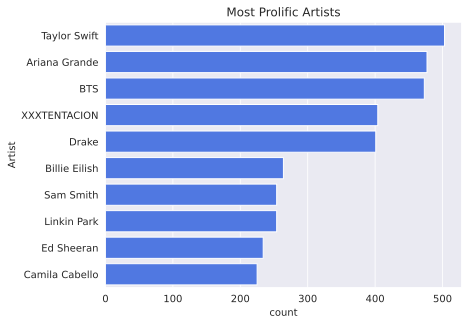

In [10]:
# same as above but with seaborn (sometimes plotly doesn't show up in the published notebok)
sns.barplot(data=result_df, y='Artist', x='count').set_title('Most Prolific Artists');

In [11]:
df.show(5)

+-----------+--------------------+-----------------+----------+------------+------------+-----------------+----------------+--------+----------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+-

`CreateOrReplaceTempView` will create a temporary view of the table on memory. It won't persist, but you can run SQL queries on top of it. You can always force it to cache/persits with `saveAsTable`.

In [12]:
df.createOrReplaceTempView("df_table")

In [13]:
print("Now using the SQL Context. We can check it's the same length as before")
query = """
    SELECT Count(*) as Dataset_Length
    FROM df_table
"""
res = spark.sql(query).show()

Now using the SQL Context. We can check it's the same length as before
+--------------+
|Dataset_Length|
+--------------+
|         27851|
+--------------+



In [14]:
# Most popular artist (by sum of popularity of songs) in the USA
query = """
SELECT
                                    Artist,
       ROUND(SUM(Popularity), 2) AS Populartiy
FROM df_table
WHERE USA == 1
GROUP BY Artist
ORDER BY AVG(Popularity) DESC
LIMIT 10
"""

res = spark.sql(query)
res.show(10, truncate=False)



+------------------------------+----------+
|Artist                        |Populartiy|
+------------------------------+----------+
|Roddy Ricch                   |106599.15 |
|Post Malone - 21 Savage       |93936.45  |
|Billie Eilish - Khalid        |79693.9   |
|Marshmello - Bastille         |74560.5   |
|Cardi B - Bad Bunny - J Balvin|74381.6   |
|Arizona Zervas                |72755.85  |
|Kendrick Lamar - Zacari       |67838.15  |
|blackbear                     |60836.35  |
|Sam Hunt                      |60696.25  |
|Sheck Wes                     |58448.95  |
+------------------------------+----------+



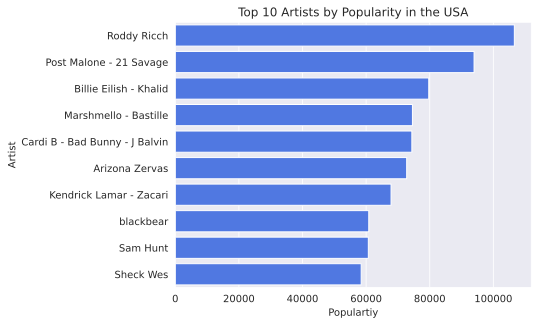

In [15]:
result_df = res.toPandas()

# make sure column names match between result_df and the arguments


sns.barplot(data=result_df, y='Artist', x='Populartiy').set_title('Top 10 Artists by Popularity in the USA') # x='Populartiy'
plt.show()

In [16]:
# select only the songs released in 1949
(df.filter(F.year(df['Release_date']) == 1949)
   .select('Title', 'Artist','Release_date', 'Genre')
   .distinct()
   .show(5, truncate=False)
)

+-----+------+------------+-----+
|Title|Artist|Release_date|Genre|
+-----+------+------------+-----+
+-----+------+------------+-----+



### Most Popular Song per Decade
First with a nested query and using pandas to drop duplicates. Then optimized with [scalar-aggregate reduction](https://www.stevenmoseley.com/blog/tech/high-performance-sql-correlated-scalar-aggregate-reduction-queries)

In [17]:
query = """
SELECT
        ROUND(Year(Release_date), -1) AS Decade,
        Round(Popularity, 2)          AS Popularity,
                                         Title,
                                         Artist
FROM df_table
INNER JOIN (SELECT Max(Popularity) as mp
            FROM df_table
            WHERE ROUND(Year(Release_date), -1) IS NOT NULL
            AND USA == 1
            GROUP BY ROUND(Year(Release_date), -1)
           ) AS temp
ON temp.mp = df_table.Popularity
ORDER BY Decade ASC, Popularity ASC
"""

res = spark.sql(query)
res.toPandas().drop_duplicates(subset='Decade', keep="last")

,Decade,Popularity,Title,Artist
0,NaN,79.20,mistletoe and holly - remastered 1999,Frank Sinatra
1,1940.0,12351.15,white christmas,Bing Crosby - Ken Darby Singers - John Scott T...
2,1950.0,997.60,mele kalikimaka,Bing Crosby - The Andrews Sisters
3,1960.0,7028.30,jingle bell rock,Bobby Helms
5,1970.0,884.45,what christmas means to me,Stevie Wonder
6,1980.0,79.20,you shook me all night long,AC/DC
7,1990.0,32076.40,all i want for christmas is you,Mariah Carey
10,2000.0,9476.05,feliz navidad,José Feliciano
13,2010.0,9698.15,mistletoe,Justin Bieber
43,2020.0,9961.25,felices los 4,Maluma


In [18]:
# highly optimized version of the above query via scalar-aggregate-reduction
query = """
SELECT
    ROUND(Year(Release_date), -1) as Decade,
    ROUND(Max(Popularity), 2) as Popularity,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Title)), 12) AS Title,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Artist)), 12) AS Artist
FROM
    df_table
WHERE
    ROUND(Year(Release_date), -1) IS NOT NULL
    AND USA == 1
GROUP BY Decade
ORDER BY Decade ASC
"""

spark.sql(query).show()

+------+----------+--------------------+--------------------+
|Decade|Popularity|               Title|              Artist|
+------+----------+--------------------+--------------------+
|  1940|  12351.15|     white christmas|Bing Crosby - Ken...|
|  1950|     997.6|     mele kalikimaka|Bing Crosby - The...|
|  1960|    7028.3|    jingle bell rock|         Bobby Helms|
|  1970|    884.45|what christmas me...|       Stevie Wonder|
|  1980|      79.2|wonderful christm...|      Paul McCartney|
|  1990|   32076.4|all i want for ch...|        Mariah Carey|
|  2000|   9476.05|       feliz navidad|      José Feliciano|
|  2010|   9698.15|happy xmas  - rem...|John Lennon - The...|
|  2020|   9961.25|       felices los 4|              Maluma|
+------+----------+--------------------+--------------------+



### Most popular Genre per decade

In [19]:
 # Most popular genres, period.
query = """
SELECT Genre, COUNT(*) AS Tally
FROM df_table
GROUP BY Genre
ORDER BY Tally DESC
"""
spark.sql(query).show(5)

+-----------+-----+
|      Genre|Tally|
+-----------+-----+
|  dance pop| 6979|
|        pop| 2133|
|      latin| 1191|
|    emo rap|  935|
|atl hip hop|  919|
+-----------+-----+
only showing top 5 rows



In [20]:
query = """
SELECT
      ROUND(Year(Release_date), -1) AS Decade,
      Genre, COUNT(Genre)           AS counts
FROM  df_table
WHERE ROUND(Year(Release_date), -1) IS NOT NULL
GROUP BY Decade, Genre
ORDER BY COUNT(Genre) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['Decade'])
            .orderBy('Decade')
            .show()
      )
# res.toPandas().drop_duplicates(subset='Decade', keep="first")

+------+-----------------+------+
|Decade|            Genre|counts|
+------+-----------------+------+
|  1940|  adult standards|    28|
|  1950|  adult standards|    28|
|  1960|  adult standards|    60|
|  1970|     classic soul|    61|
|  1980|       album rock|   158|
|  1990|        dance pop|    46|
|  2000|alternative metal|    99|
|  2010|        dance pop|   172|
|  2020|        dance pop|  6635|
+------+-----------------+------+



## For each track, what day was it most popular?
(Just for a small selection of them)

In [21]:
query = """
SELECT Title, Artist, Release_date, MAX(Popularity)
FROM df_table
WHERE Artist == "Paulo Londra"
GROUP BY Title, Artist, Release_date
LIMIT 10
"""

res = spark.sql(query).show()

+-------------+------------+------------+-----------------+
|        Title|      Artist|Release_date|  max(Popularity)|
+-------------+------------+------------+-----------------+
|   adan y eva|Paulo Londra|  2018-11-05|849.6000000000001|
|forever alone|Paulo Londra|  2019-02-13|            644.8|
|      tal vez|Paulo Londra|  2019-04-03|7515.750000000001|
+-------------+------------+------------+-----------------+



## Let's see how music changed over the decades

In [22]:
sound_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']
col_names = ['Decade']
col_names.extend(sound_features)

df_music_features = (df.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )
fig = px.line(df_music_features, x='Decade', y=sound_features, title='Song Characteristics Over the Decades')
fig.show()

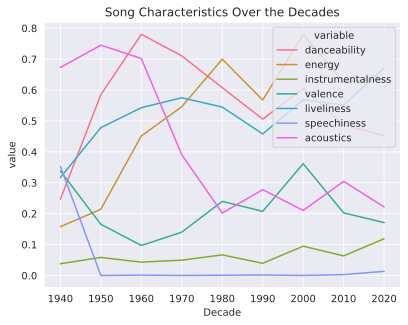

In [23]:
# same as above but with seaborn. (sometimes plotly doesn't show up in the published notebok)
sns.lineplot(data=pd.melt(df_music_features, ['Decade']), x='Decade', y='value', hue='variable').set_title('Song Characteristics Over the Decades');

# Clustering

## First check out the cosine similiarty of song feature vectors

In [24]:
###### First query_usa ######
query_usa = """
SELECT Title, Artist, {}
FROM df_table
WHERE `USA` = 1
""".format(', '.join(numerical_features))

df_usa_songs = (spark.sql(query_usa)
                      .sample(.1)
                      .dropna()
                      .toPandas() # don't do this, it's better to sample before querying
                )
####### Now Rap #######
query_rap = """
SELECT Title, Artist, {}
FROM df_table
WHERE rap = 1
""".format(', '.join(numerical_features))

df_rap_songs = (spark.sql(query_rap)
                     .sample(.1)
                     .dropna()
                     .toPandas() # don't do this, it's better to sample before querying
               )
df_rap_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,betrayed,Lil Xan,0.821,0.434,0.0,0.241,0.128,0.118,0.434,0.0,120.012001,187173.0,4.0,953.0,346.0
1,japan,Famous Dex,0.733,0.678,0.0,0.841,0.345,0.439,0.121,0.0,175.983994,144149.0,4.0,974.0,531.0
2,japan,Famous Dex,0.733,0.678,0.0,0.841,0.345,0.439,0.121,0.0,175.983994,144149.0,4.0,974.0,531.0
3,japan,Famous Dex,0.733,0.678,0.0,0.841,0.345,0.439,0.121,0.0,175.983994,144149.0,4.0,974.0,531.0
4,do you remember,Chance the Rapper - Death Cab for Cutie,0.606,0.655,0.0,0.696,0.103,0.402,0.139,0.0,159.824005,236686.0,4.0,477.0,221.0


In [25]:
df_usa_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,it wont kill ya,The Chainsmokers - Louane,0.572,0.530,0.000169,0.120,0.127,0.0654,0.0647,0.000169,170.138000,217613.0,4.0,1314.0,274.0
1,living proof,Camila Cabello,0.735,0.514,0.000000,0.517,0.359,0.0820,0.1090,0.000000,77.566002,194440.0,4.0,365.0,293.0
2,do you remember,Chance the Rapper - Death Cab for Cutie,0.606,0.655,0.000000,0.696,0.103,0.4020,0.1390,0.000000,159.824005,236686.0,4.0,477.0,221.0
3,nowadays,Lil Skies - Landon Cube,0.745,0.646,0.000000,0.460,0.338,0.1700,0.1570,0.000000,79.992996,203908.0,4.0,1068.0,130.0
4,all around me,Justin Bieber,0.566,0.438,0.000000,0.692,0.212,0.0367,0.8090,0.000000,117.126999,136907.0,4.0,274.0,193.0


In [26]:
# it might be better to used a normalized cosine similarity instead of scaling first and then doing it.
from scipy import spatial
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
transformer = Normalizer()

scaled_usa_df = scaler.fit_transform(df_usa_songs.iloc[:, 2:]) # drop the title and artist with the iloc
scaled_rap_df = scaler.fit_transform(df_rap_songs.iloc[:, 2:])


# cos similarity of a rap and a k-pop song
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_usa_df[2])
result = 1 - spatial.distance.cosine(song1, song2)
print("Cosine similarity of a rap and a usa song:", result)

Cosine similarity of a rap and a usa song: 0.9241468045759581


In [27]:
# cos similarity of two rap songs
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_rap_df[10])
result = 1 - spatial.distance.cosine(song1, song2)
print("Cosine similarity of two rap songs:", result)

Cosine similarity of two rap songs: 0.8807599040430228


## Dimentionality reduction
This is useful for visualizing kmeans clustering later. One mistake people make with PCA, is assuming that the dimentions you get will be interpretable. In this case, we're going to take two types of music (USA and Rap), and then try reducing all the numeric, musical features down to two dimentions. The two dimentions won't really represent the genre of the music, but we can pretend that this is true. When we do KMeans clustering later on, we can visualize it on these two PCA axes.

In [28]:
# let's add an OHE genre encoding
df_rap_songs = df_rap_songs.assign(is_rap=1,
                                   is_usa=0
                                   )
df_usa_songs = df_usa_songs.assign(is_rap=0,
                                     is_usa=1
                                     )
df_rap_and_usa = pd.concat([df_rap_songs, df_usa_songs])
X = scaler.fit_transform(df_rap_and_usa.iloc[:, 2:])

pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.52502978 0.09959264 0.07871588 0.0679184  0.05628617 0.04804907
 0.03381027 0.03264639 0.02112465 0.01402021]


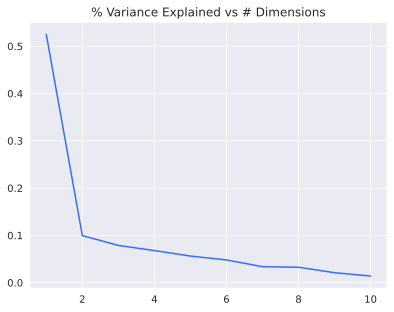

In [29]:
sns.lineplot(x=[x for x in range(1, 11)], y=pca.explained_variance_ratio_).set_title("% Variance Explained vs # Dimensions");

As expected, it's able to explain most the vairance using 1 dimension. This roughly corresponds to "genre," which instead was encoded as either `is_rap` or `is_query_usa`

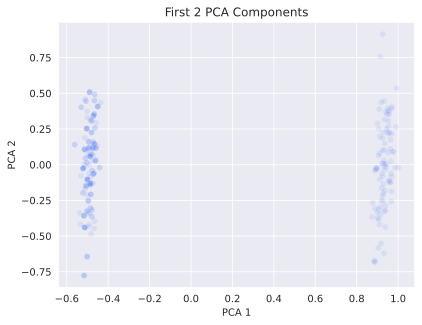

In [30]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principalComponents)

# sns.scatterplot(data=principalComponents, alpha=.1)
sns.scatterplot(x=PCA_components[0], y=PCA_components[1], alpha=.1).set_title("First 2 PCA Components");
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');

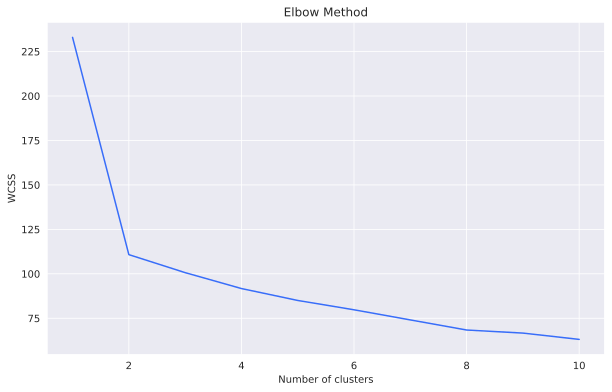

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Sử dụng dữ liệu đã chuẩn hóa trước đó (X_scaled)
# Giả sử X_scaled đã được chuẩn hóa và là đầu vào cho mô hình

# Nếu X_scaled chưa chuẩn hóa thì thực hiện chuẩn hóa lại
# X_scaled = scaler.fit_transform(X)
# Tìm số cụm tối ưu bằng Elbow Method
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [40]:
# Giả sử từ Elbow Method, số cụm tối ưu là 3
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Thêm nhãn cụm vào DataFrame
df_rap_and_usa['Cluster'] = clusters

# In kết quả phân cụm
print(df_rap_and_usa[['Title', 'Artist', 'Cluster']].head(10))


                Title                                   Artist  Cluster
0            betrayed                                  Lil Xan        0
1               japan                               Famous Dex        2
2               japan                               Famous Dex        2
3               japan                               Famous Dex        2
4     do you remember  Chance the Rapper - Death Cab for Cutie        2
5         ball for me                Post Malone - Nicki Minaj        2
6             revenge                             XXXTENTACION        0
7             revenge                             XXXTENTACION        0
8            nowadays                  Lil Skies - Landon Cube        0
9  houstonfornication                             Travis Scott        0


Cluster
0    117
1     92
2     58
Name: count, dtype: int64


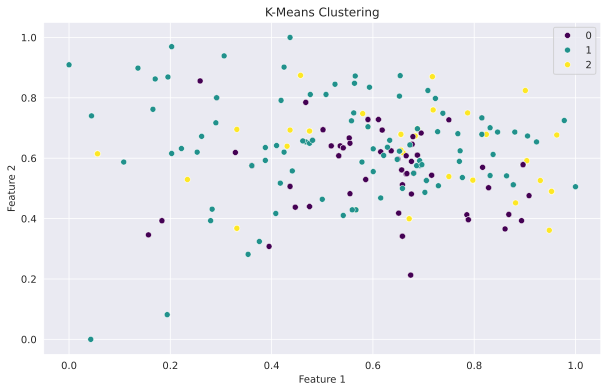

In [43]:
# Tính toán số lượng bài hát trong mỗi cụm
print(df_rap_and_usa['Cluster'].value_counts())

# Vẽ biểu đồ để trực quan hóa các cụm
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters, palette='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
